In [1]:
import os

In [14]:
# Use CPU instead
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [20]:
import os

import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAvgPool2D, Dense
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.applications import MobileNetV2

tfds.disable_progress_bar()

from matplotlib import pyplot as plt

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
SPLIT_WEIGHTS = (8, 1, 1)
splits = tfds.Split.TRAIN.subsplit(weighted=SPLIT_WEIGHTS)

(raw_train, raw_validation, raw_test), metadata = tfds.load(
    'cats_vs_dogs', split=list(splits),
    with_info=True, as_supervised=True)

In [5]:
print(raw_train)
print(raw_validation)
print(raw_test)

<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>
<_OptionsDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


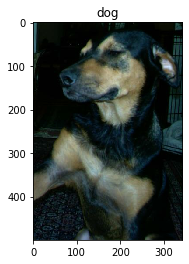

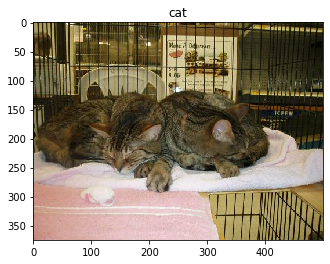

In [6]:
get_label_name = metadata.features['label'].int2str

for image, label in raw_train.take(2):
    plt.figure()
    plt.imshow(image)
    plt.title(get_label_name(label))

In [7]:
IMG_SIZE = 160

def format_example(image, label):
    image = tf.cast(image, tf.float32)
    image = (image/127.5) - 1
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

In [8]:
train = raw_train.map(format_example)
validation = raw_validation.map(format_example)
test = raw_test.map(format_example)

In [9]:
BATCH_SIZE = 32
SHUFFLE_BUFFER_SIZE = 1000

In [10]:
train_batches = train.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
validation_batches = validation.batch(BATCH_SIZE)
test_batches = test.batch(BATCH_SIZE)

In [11]:
for image_batch, label_batch in train_batches.take(1):
    pass

image_batch.shape

TensorShape([32, 160, 160, 3])

In [12]:
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

base_model = MobileNetV2(input_shape=IMG_SHAPE,
                         include_top=False,
                         weights='imagenet')

In [13]:
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [15]:
base_model.trainable = False
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 161, 161, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [19]:
model = Sequential([
    base_model,
    GlobalAvgPool2D(),
    Dense(1)
])

In [21]:
model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [24]:
num_train, num_val, num_test = (
    metadata.splits['train'].num_examples*weight/10
    for weight in SPLIT_WEIGHTS)

In [29]:
initial_epochs = 10
steps_per_epoch = round(num_train)//BATCH_SIZE
validation_steps = 20

loss0, accuracy0 = model.evaluate(validation_batches, steps=validation_steps)

20/20 [==============================] - 10s 478ms/step - loss: 4.9225 - accuracy: 0.5578


In [30]:
print(f'inital loss: {loss0:.2f}')
print(f'initial accuracy: {accuracy0:.2f}')

inital loss: 4.92
initial accuracy: 0.56


In [31]:
history = model.fit(train_batches,
                    epochs=initial_epochs,
                    validation_data=validation_batches)

Epoch 1/10
582/582 [==============================] - 473s 812ms/step - loss: 2.6164 - accuracy: 0.6827 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/10
582/582 [==============================] - 449s 772ms/step - loss: 1.2023 - accuracy: 0.8404 - val_loss: 0.7935 - val_accuracy: 0.9060
Epoch 3/10
582/582 [==============================] - 451s 775ms/step - loss: 0.8313 - accuracy: 0.8885 - val_loss: 0.7057 - val_accuracy: 0.9172
Epoch 4/10
582/582 [==============================] - 449s 771ms/step - loss: 0.6942 - accuracy: 0.9052 - val_loss: 0.5918 - val_accuracy: 0.9384
Epoch 5/10
582/582 [==============================] - 450s 772ms/step - loss: 0.6077 - accuracy: 0.9174 - val_loss: 0.5297 - val_accuracy: 0.9431
Epoch 6/10
582/582 [==============================] - 458s 787ms/step - loss: 0.5737 - accuracy: 0.9261 - val_loss: 0.5007 - val_accuracy: 0.9478
Epoch 7/10
582/582 [==============================] - 458s 788ms/step - loss: 0.5177 - accuracy: 0.9299 - val_loss: 

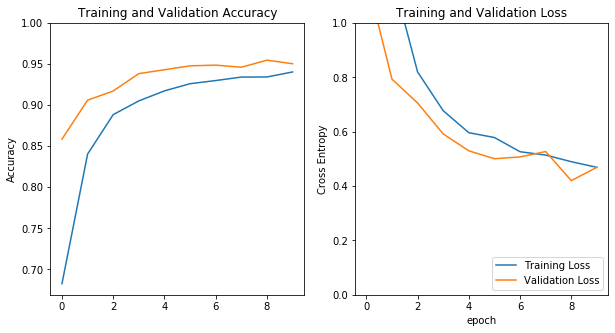

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc=4)
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [33]:
base_model.trainable = True

In [34]:
print(f"Number of layers in the base model: {len(base_model.layers)}")

fine_tune_at = 100

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

Number of layers in the base model: 155


In [35]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(1e-5),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_160 (Model) (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1281      
Total params: 2,259,265
Trainable params: 1,863,873
Non-trainable params: 395,392
_________________________________________________________________


In [36]:
fine_tune_epochs = 10
total_epochs = initial_epochs + fine_tune_epochs

history_fine = model.fit(train_batches,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_batches)

Epoch 10/20
582/582 [==============================] - 566s 973ms/step - loss: 0.4015 - accuracy: 0.9479 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 11/20
582/582 [==============================] - 563s 967ms/step - loss: 0.3092 - accuracy: 0.9593 - val_loss: 0.2550 - val_accuracy: 0.9728
Epoch 12/20
582/582 [==============================] - 563s 967ms/step - loss: 0.2999 - accuracy: 0.9623 - val_loss: 0.2387 - val_accuracy: 0.9733
Epoch 13/20
582/582 [==============================] - 561s 965ms/step - loss: 0.2546 - accuracy: 0.9685 - val_loss: 0.2179 - val_accuracy: 0.9750
Epoch 14/20
582/582 [==============================] - 569s 978ms/step - loss: 0.2340 - accuracy: 0.9716 - val_loss: 0.2135 - val_accuracy: 0.9720
Epoch 15/20
582/582 [==============================] - 583s 1s/step - loss: 0.2093 - accuracy: 0.9750 - val_loss: 0.2388 - val_accuracy: 0.9746
Epoch 16/20
582/582 [==============================] - 568s 976ms/step - loss: 0.1690 - accuracy: 0.9793 - val_lo

In [37]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

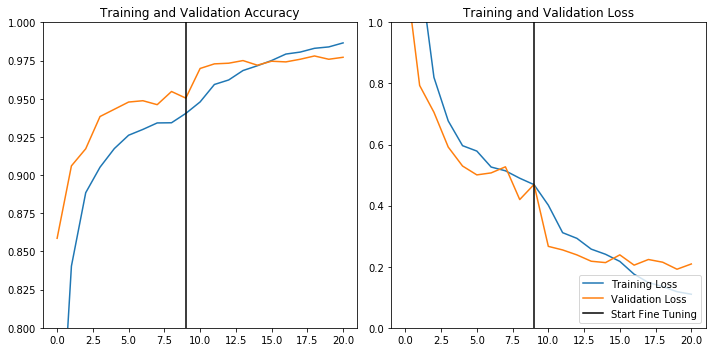

In [43]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.axvline(initial_epochs-1, label='Start Fine Tuning', color='k')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.axvline(initial_epochs-1, label='Start Fine Tuning', color='k')
plt.legend(loc=4)
plt.title('Training and Validation Loss')

plt.tight_layout()